Blackjack World 2018-08-20 10:34:52.285388


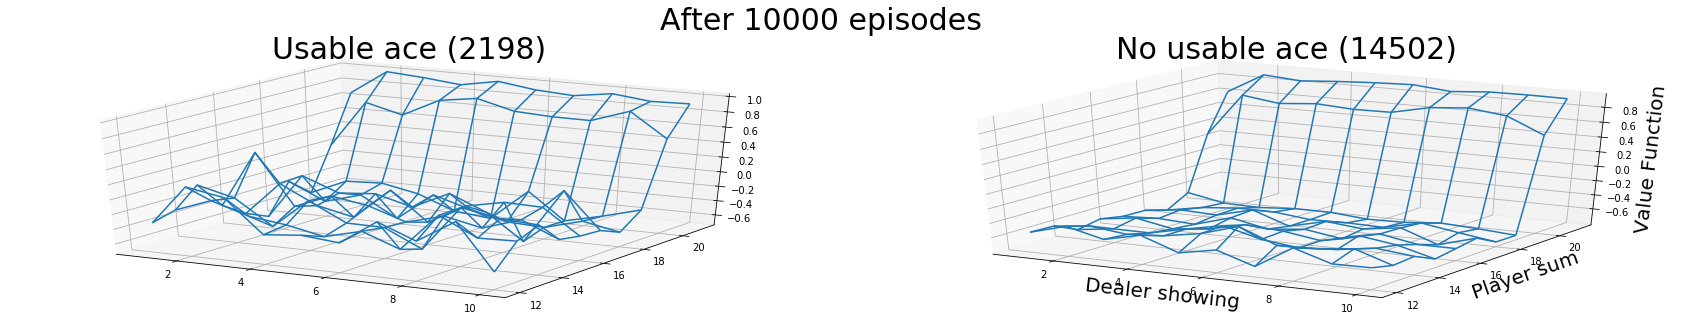

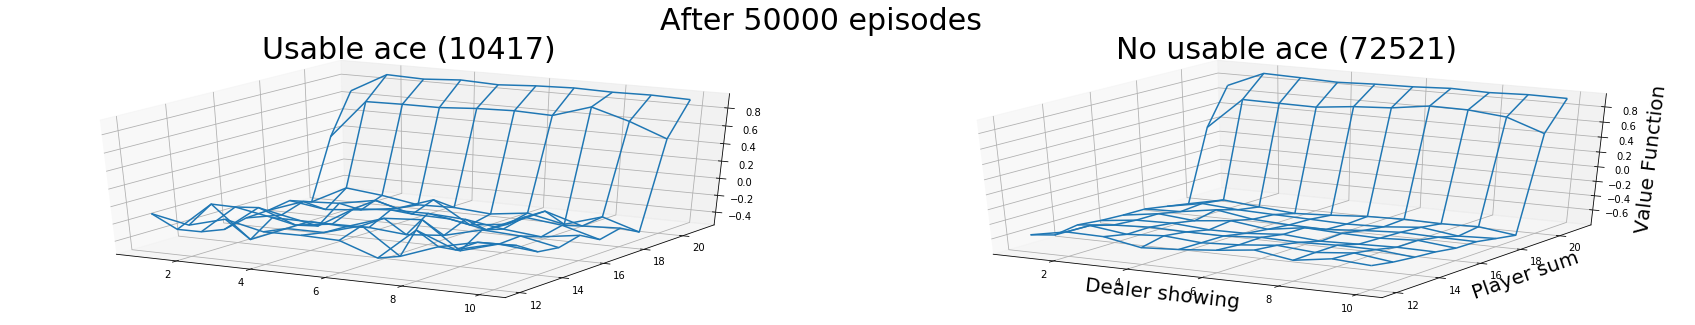

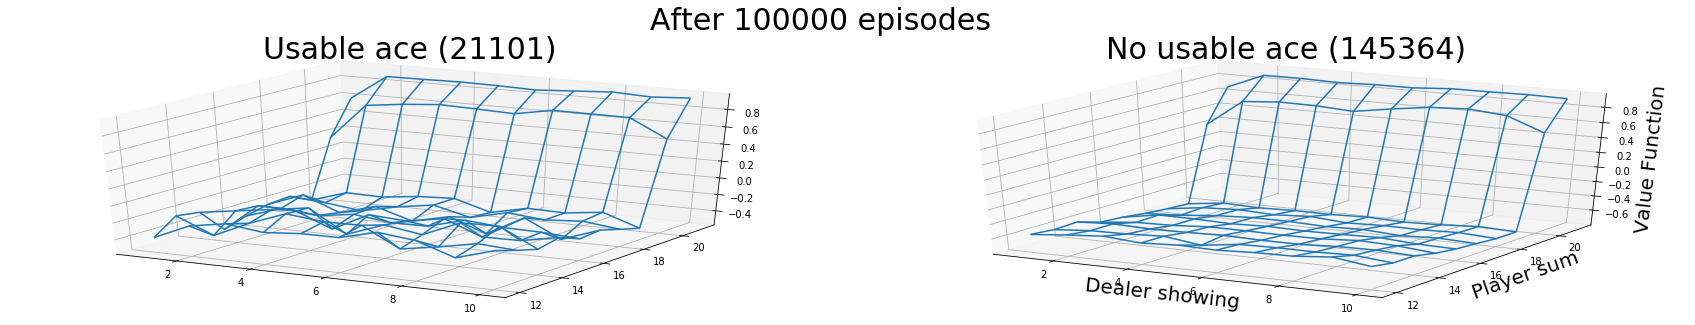


Blackjack World 2018-08-20 10:35:02.817396
Running Time 0:00:10.532008


In [157]:
"""Example 5.1 Blackjack
Author : SeongJin Yoon
"""
import random
import numpy as np
from enum import Enum
import itertools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import datetime as dt

class ConfigDict(dict):
    def __init__(self, *args, **kwargs): super().__init__(*args, **kwargs)
    def __getattr__(self, name): return self[name]
    def __setattr__(self, name, value): self[name] = value
    def __delattr__(self, name): del self[name]
        
config = ConfigDict()
config.env = ConfigDict(max_capital = 99, goal = 21)
config.value = ConfigDict(discount = 1.0, theta = 1e-200)
config.state = ConfigDict(terminal = [21])

class Reward(Enum):
    """Reward classes."""
    win = 1
    lose = 2
    draw = 3
    
class Game(Enum):
    """Game classes."""
    ongoing = 0
    win = 1
    lose = 2
    draw = 3
    
class Action(Enum):
    """Action classes."""
    stick = 0
    hit = 1
    
class Terminal(Enum):
    """Terminal classes."""
    none = 0
    bust = 1
    natural = 2
    
class Plot():
    """Plot classes."""
    def __init__(self, nrows, ncols, figsize, title, projection=None):
        self.fig_idx = 0
        
        if projection == None:
            self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        else:
            self.fig, self.axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, 
                                        subplot_kw=dict(projection=projection))
        self.fig.suptitle(title, fontsize=30)

        plt.subplots_adjust(wspace=0.1, hspace=0.2)
        self.axes = self.axes.flatten()
    # plot a policy/state value matrix
    def draw_heatmap(self, xticks, yticks, data, labels):
        fig = sns.heatmap(data, cmap="YlGnBu", ax=self.axes[self.fig_idx], 
                          xticklabels=xticks, yticklabels=yticks)
        #fig.set_xticks(axisX)
        #fig.set_yticks(axisY)

        fig.set_xlabel(labels[0], fontsize=30)
        fig.set_ylabel(labels[1], fontsize=30)
        fig.set_title(labels[2], fontsize=30)
        self.fig_idx += 1
        
    # plot a policy/state value matrix
    def draw_scatter(self, axisX, axisY, axisZ, labels, title):
        ax=self.axes[self.fig_idx]

        ax.scatter(axisX, axisY, axisZ)
        if labels != None:
            ax.set_xlabel(labels[0], fontsize=20)
            ax.set_ylabel(labels[1], fontsize=20)
            ax.set_zlabel(labels[2], fontsize=20)
        if title != None:
            ax.set_title(title, fontsize=30)
        self.fig_idx += 1

    def draw_wirefame(self, axisX, axisY, axisZ, labels, title):
        ax=self.axes[self.fig_idx]

        ax.plot_wireframe(axisX, axisY, axisZ)
        if labels != None:
            ax.set_xlabel(labels[0], fontsize=20)
            ax.set_ylabel(labels[1], fontsize=20)
            ax.set_zlabel(labels[2], fontsize=20)
        if title != None:
            ax.set_title(title, fontsize=30)
        self.fig_idx += 1


    def save(self, title):
        plt.savefig(title)

    def show(self):
        plt.show()

    def close(self, title):
        plt.close()

class Card():
    """Card classes."""
    def __init__(self):
        self.shape = "Spade"
        self.number = "A"
        self.score = 1
        self.is_ace = True
        
    def calc_score(self, usable=False):
        if self.number == 'A':
            if usable:
                return 11
            else:
                return 1
        elif self.number in ['J', 'Q', 'K']:
            return 10
        else:
            return self.number

class CardDeck():
    """CardDeck classes."""
    def __init__(self):
        card_shape_list = ["Spade", "Heart", "Clover", "Diamond"]
        card_number_list = ['A'] + list(range(2, 10)) + ['J', 'Q', 'K']
        self.card_list = list(itertools.product(card_shape_list,
                                                card_number_list))
        self.card_deck = []
        for shape in card_shape_list:
            for number in card_number_list:
                card = Card()
                card.shape = shape
                card.number = number
                is_ace = lambda x: x == 'A'
                card.is_ace = is_ace(card.number)
                card.score = card.calc_score()
                self.card_deck.append(card)

    def pick_a_card(self):
        deck_size = len(self.card_deck)
        card_idx = random.randint(0, deck_size-1)
        return self.card_deck[card_idx]

class Turn():
    """Turn classes."""
    def __init__(self):
        self.card_sum = 0
        self.counterpart_card = 0
        self.usable = False
        self.action = Action.hit
        self.reward = 0
    
    def get_state(self):
        return self.card_sum, self.counterpart_card, self.usable
        
    def print_turn(self):
        format_str = "[card_sum %d, counterpart_card %d, usable %r], action %s"
        value = (self.card_sum, self.counterpart_card, self.usable, self.action)
        if self.action == Action.hit:
            format_str += ", card number %s, score %d"
            card = self.card
            value += (card.number, card.score)

        print(format_str % value)

class TurnTrajectory():
    """TurnTrajectory classes."""
    def __init__(self):
        self.turn_list = []
        
    def add(self, turn):
        self.turn_list.append(turn)
    
    def length(self, step=-1):
        return len(self.turn_list)
    
    def get(self, step=-1):
        turn = self.turn_list[step]
        return turn

    def update(self, step, turn):
        self.turn_list[step] = turn
    
    def is_first_state(self, state, step):
        for turn in self.turn_list[:step-1]:
            if state == turn.get_state():
                return False
        return True

    def print_trajectory(self):
        for turn in self.turn_list:
            turn.print_turn()

        
    def __call__(self, step=-1):
        return self.get(step)
   
class Environment():
    """Environment classes."""
    def __init__(self):
        self.prepare_environment()
        
    def prepare_environment(self):
        # for making state list
        self.player_card_sum_list = list(range(12, 21+1))
        self.dealer_card_list = list(range(1, 10+1))
        self.usable_list = list([True, False])
        
        # make reward list
        self.reward_list = {Reward.win : 1, Reward.lose : -1, Reward.draw : 0}
        
        # make card and dealer
        self.card_deck = CardDeck()
        self.dealer = Dealer(self, self.card_deck)

    def get_reward(self, reward_type):
        return self.reward_list[reward_type]

    def check_terminal(self, card_sum):
        if card_sum > config.env.goal:
            return Terminal.bust
        elif card_sum == config.env.goal:
            return Terminal.natural
        else:
            return Terminal.none
        
    def is_usable(self, card_sum, card):
        if card.is_ace:
            if (card_sum + 11) <= 21:
                return True
        return False

    def pick_a_card(self):
        card  = self.card_deck.pick_a_card()
        return card

class Player():
    """Player classes."""
    def __init__(self, env):
        self.env = env
        self.card_sum = 0
        self.num_ace = 0
        self.ace_usable = False
        self.counterpart_card = 0
        
    def start_game(self):
        self.card_sum = 0
        self.num_ace = 0
        self.ace_usable = False
        self.counterpart_card = 0
        
        self.turn_trajectory = TurnTrajectory()
        self.play()
        
    def get_policy(self, card_sum):
        if card_sum >= 20:
            return Action.stick
           
        return Action.hit
    
    def play(self):

        turn = Turn()
        turn.card_sum = self.card_sum
        turn.counterpart_card = self.counterpart_card
        turn.usable = self.ace_usable
        
        turn.action = self.get_policy(self.card_sum)
        
        if turn.action == Action.stick:
            self.turn_trajectory.add(turn)
            return turn, None

        card = self.env.pick_a_card()
        self.card_sum += card.score
        
        if self.env.is_usable(self.card_sum, card):
            self.card_sum += 10
            # print("make usable card_sum %d, card %s, card score %d" %(self.card_sum, turn.card.number, turn.card.score))
            self.num_ace += 1
            self.ace_usable = True

        self.turn_trajectory.add(turn)
       
        while self.card_sum > 21 and self.ace_usable is True: # bust
            self.cancel_ace_usable()

        return turn, card

    def cancel_ace_usable(self):
        assert self.ace_usable
            
        self.card_sum -= 10
        self.num_ace -= 1
        if self.num_ace == 0:
            self.ace_usable = False

class Dealer(Player):
    """Dealer classes."""
    def __init__(self, env, card_deck):
        super().__init__(env)
        
        self.card_deck = card_deck


    def get_policy(self, card_sum):
        if card_sum < 17:
            return Action.hit
        
        return Action.stick
        
class Agent(Player):
    """Agent classes."""
    def __init__(self, env):
        super().__init__(env)
       
        self.dealer = self.env.dealer
        self.v_labels = ['Dealer showing', 'Player sum', 'Value Function']

   
    def First_visit_MC_prediction(self, num_episode):
        
        discount = config.value.discount
        discounted_return = 0        
        # 1. Initialize
        self.value_function = ValueFunction(self.env)

        episode_count = 1        
        while episode_count <= num_episode: # for each episode:
            # 2. Generate Episode
            episode = self.generate_episode()

            # 3. Update Value Function
            discounted_return = 0
            next_reward = episode.reward
            for step in range(episode.steps()-1, -1, -1):
                state, reward, action = episode.get_step(step)
                discounted_return = next_reward + discount*discounted_return

                if episode.is_first_state(state, step):
                    self.value_function(state, discounted_return)

                next_reward = reward
            episode_count += 1
            
        title = "After %d episodes" % (num_episode)
        self.plot = Plot(nrows=1, ncols=2, figsize=(30,5), title=title, projection = '3d')
        self.value_function.plot_wire(self.plot, self.v_labels)
        self.plot.show()
        
    def generate_episode(self):
       
        # 1. Setup Game
        self.start_game()
        self.dealer.start_game()
        
        episode = Episode(self.turn_trajectory, self.dealer.turn_trajectory)
        
        self.dealer.counterpart_card = self.card_sum
        self.counterpart_card = self.dealer.card_sum
        
        step = 0
        # Player's Turn
        while True:
            step += 1
            turn, card = self.play()
            #player_turn = turn
            if turn.action == Action.stick:
                break

        terminal_state = self.env.check_terminal(self.card_sum)
                
        if terminal_state == Terminal.bust:
            episode.game_state = Game.lose
            episode.terminal_state = terminal_state
            episode.reward = self.env.get_reward(Reward.lose)
            episode.ace_usable = self.ace_usable
            return episode

        # Dealer's Turn
        while True:
            step += 1
            turn, card = self.dealer.play()
            if turn.action == Action.stick:
                break
            
        terminal_state = self.env.check_terminal(self.dealer.card_sum)
            
        if terminal_state == Terminal.bust:
            episode.game_state = Game.lose
            episode.terminal_state = terminal_state
            episode.reward = self.env.get_reward(Reward.win)
            episode.ace_usable = self.ace_usable
            return episode

        # When player and dealer call "stick"
        if self.card_sum > self.dealer.card_sum:
            episode.game_state = Game.win
            episode.reward = self.env.get_reward(Reward.win)
        elif self.card_sum < self.dealer.card_sum:
            episode.game_state = Game.lose
            episode.reward = self.env.get_reward(Reward.lose)    
        else:
            episode.game_state = Game.draw
            episode.reward = 0
                
        # player_turn.reward = reward
        episode.terminal_state = terminal_state
        episode.ace_usable = self.ace_usable
        return episode

    
class Episode():
    """Episode classes."""
    def __init__(self, player_history, dealer_history):
        self.player_history = player_history
        self.dealer_history = dealer_history
        self.game_state = Game.ongoing
        self.terminal_state = Terminal.none
        self.ace_usable = False
        self.reward = 0
        
    def is_first_state(self, state, step):
        return self.player_history.is_first_state(state, step)
    
    def get(self, step=-1):
        self.player_history.get(step)

    def steps(self):
        return len(self.player_history.turn_list)
    
    def get_step(self, step):
        turn = self.player_history.get(step)
        return turn.get_state(), turn.reward, turn.action

class ValueFunction():
    """ValueFunction classes."""
    def __init__(self, env):

        self.env = env
        len1 = len(self.env.player_card_sum_list) #(12, 21)
        len2 = len(self.env.dealer_card_list) # (1, 10)
        len3 = len(self.env.usable_list) # [True, False]
        
        self.V = np.zeros((len1, len2, len3), dtype=np.float32)
        self.n = np.zeros((len1, len2, len3), dtype=np.int32)
        
        self.moving_avg = lambda old, new, n : old + 1.0/float(n)*(new - old)
        
    def card_sum_idx(self, card_sum):
        return card_sum - 12
    
    def dealer_card_idx(self, dealer_card):
        if dealer_card == 11:
            dealer_card = 1
        return dealer_card - 1    
    
    def usable_idx(self, usable):
        if usable is True:
            usable_idx=0
        else:
            usable_idx=1
        return usable_idx

    def card_sum(self, card_sum_idx):
        return card_sum_idx + 12
    
    def dealer_card(self, dealer_card_idx):
        return dealer_card_idx + 1

    def usable(self, usable_idx):
        if usable_idx == 0:
            usable = True
        else:
            usable = False
        return usable

    def validate(self, state):
        card_sum, dealer_card, usable = state
        if dealer_card == 11:
            dealer_card = 1
 
        if card_sum < 12 or card_sum > 21:
            return False
            
        if dealer_card <1 or dealer_card > 10:
            return False
    
    def index(self, state):
        card_sum, dealer_card, usable = state
        s_idx = self.card_sum_idx(card_sum)
        d_idx = self.dealer_card_idx(dealer_card)
        u_idx = self.usable_idx(usable)
        return s_idx, d_idx, u_idx
        
    def __call__(self, state, new_value):
        
        if self.validate(state) == False:
            return
            
        s_idx, d_idx, u_idx = self.index(state)
        
        # moving average
        old_value = self.V[s_idx, d_idx, u_idx]
        n = self.n[s_idx, d_idx, u_idx]+1
        avg = self.moving_avg(old_value, new_value, n)
        
        card_sum, dealer_card, usable = state
        
        self.V[s_idx, d_idx, u_idx] = avg
        self.n[s_idx, d_idx, u_idx] += 1
        
    def plot_wire(self, plot, label):

        len1 = len(self.env.dealer_card_list) # (1, 10)
        len2 = len(self.env.player_card_sum_list) #(12, 21)

        axisX, axisY = np.meshgrid(self.env.dealer_card_list,
                                   self.env.player_card_sum_list)
        
        axisZ_usable = np.reshape(self.V[:, :, 0], (len1, len2))
        axisZ_no_usable = np.reshape(self.V[:, :, 1], (len1, len2))
        
        usable_update = np.sum(self.n[:, :, 0])
        no_usable_update = np.sum(self.n[:, :, 1])
        # usable ace
        title = "Usable ace (%d)" % (usable_update)
        plot.draw_wirefame(axisX, axisY, axisZ_usable, None, title=title)
        # no usable ace
        title = "No usable ace (%d)" % (no_usable_update)
        plot.draw_wirefame(axisX, axisY, axisZ_no_usable, label, title=title)

        plot.show() 
                
    def plot_heatmap(self, plot, label):

        len1 = len(self.env.player_card_sum_list) #(12, 21)
        len2 = len(self.env.dealer_card_list) # (1, 10)

        xticklabels=range(1, 11)
        yticklabels=list(reversed(range(12, 22)))

        axisZ_usable = np.reshape(self.V[:, :, 0], (len1, len2))
        axisZ_no_usable = np.reshape(self.V[:, :, 1], (len1, len2))
        
        plot.draw_heatmap(xticklabels, yticklabels, np.flipud(axisZ_usable), label)
        plot.draw_heatmap(xticklabels, yticklabels, np.flipud(axisZ_no_usable), label)
        
if __name__ == "__main__":
    begin_time = dt.datetime.now()
    print("Blackjack World", begin_time)
    
    env = Environment()
    agent = Agent(env)
    agent.First_visit_MC_prediction(num_episode=10000)
    agent.First_visit_MC_prediction(num_episode=50000)
    agent.First_visit_MC_prediction(num_episode=100000)
    end_time = dt.datetime.now()
    
    print()
    print("Blackjack World", end_time)
    print("Running Time", end_time - begin_time)
